In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(10),
transforms.RandomAffine(0, shear=10, scale=(.8, 1.2)), #shear: 'shift' part of shape in x/y axis i.e. paralellogram-ise. scale 80-120% size
transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
transforms.ToTensor(),
transforms.Normalize((.5,), (.5,))])

transform = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(), #numpy array of range 0-255 --> float tensor of range 0-1
transforms.Normalize((.5,), (.5,))]) # norm. vals for each tensor of image size: channel, h, w. first bracket: mean val to normalise all channels in tensor image. second: SD. want range of 0-1 and -1-0
# reduces skewness and distorions is data - more effective learning

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) #subset of training data. changes if shuffle - prevents getting caught in local minima
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    #image = image.to(device)
    image = image.transpose(1,2,0) #MNIST - greyscale, 28*28px = 28*28*1 tensor. transpose tensor from c,w,h to w,h,c
    #print(image.shape)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denorm.
    image = image.clip(0, 1) #make sure range is back to 0-1, vs -1-1
    return image

In [35]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

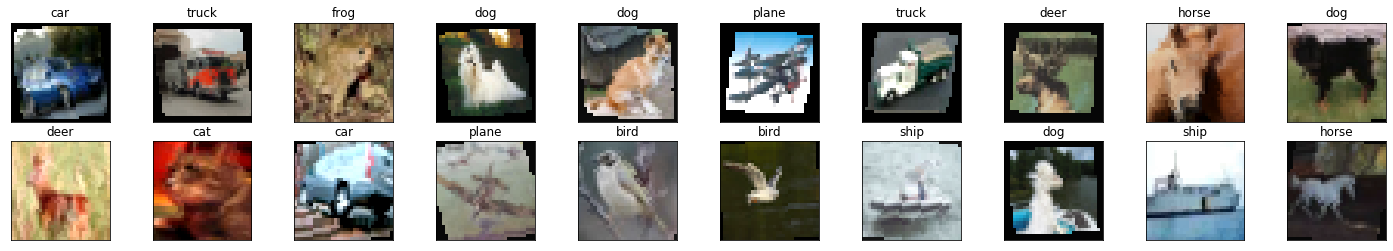

In [36]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4)) # w x h

for index in np.arange(20):
    ax = fig.add_subplot(2, 10, index + 1, xticks=[], yticks=[]) # r, c, index: pos. of subplot 
    plt.imshow(img_convert(images[index]))
    ax.set_title(classes[labels[index].item()])

In [37]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) #input channels (3 for RGB), output, kernel size, stride length
        self.conv2 = nn.Conv2d(16, 32, 3, 1,padding=1) #img size half at every layer
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5) #dropout rate
        self.fc2 = nn.Linear(500, 10) #10 classes in CIFAR
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) #2*2 size of max pooling kernel ie halves
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64) #reshape - flattened for fcl. col*row. 2: output shape of data from prev maxpool layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) #between fcls since high parameter layers - more likely to overfit and memorise training layer
        x = self.fc2(x) #multiclass data set so no activ func on last layer - passed via cross entropy loss
        return x

In [38]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [39]:
criterion = nn.CrossEntropyLoss() #for classification problems with n clases
optimiser = torch.optim.Adam(model.parameters(), lr = .001,)

In [40]:
epochs = 15
running_loss_history = []
running_corrects_history = [] #accuracy per epoch
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = .0
    running_corrects = .0
    val_running_loss = .0
    val_running_corrects = .0
    

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #inputs = inputs.view(inputs.shape[0], -1) #full 28*28 passed in to be convulved by kernel so line not required
        outputs = model(inputs) #scores
        loss = criterion(outputs, labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        _, preds = torch.max(outputs, 1) #top score per image. highest score in index x --> predict image belongs to class x
        running_corrects += torch.sum(preds == labels.data) #cmp to labels. if matching return 1 else 0. total
        running_loss += loss.item()


    else:
        with torch.no_grad(): #testing not training
            for val_inputs, val_labels in validation_loader:
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1) #full 28*28 passed in to be convulved by kernel so line not required
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()


        epoch_loss = running_loss / len(training_loader)
        epoch_acc  = running_corrects.float() / len(training_loader) #no. batches
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc  = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss) # loss at every epoch
        val_running_corrects_history.append(val_epoch_acc)

        print("epoch :", (e+1))
        print("training loss: {:.4f}, acc {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, acc {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch :1
training loss: 1.6770, acc 38.2960
validation loss: 1.3911, acc 49.7800
epoch :2
training loss: 1.3770, acc 50.3100
validation loss: 1.2069, acc 56.6600
epoch :3
training loss: 1.2531, acc 55.0440
validation loss: 1.0929, acc 61.2200
epoch :4
training loss: 1.1676, acc 58.4380
validation loss: 1.0368, acc 62.9100
epoch :5
training loss: 1.0992, acc 60.9720
validation loss: 1.0032, acc 64.4900
epoch :6
training loss: 1.0586, acc 62.5160
validation loss: 0.9456, acc 67.0300
epoch :7
training loss: 1.0147, acc 64.1620
validation loss: 0.9235, acc 67.3400
epoch :8
training loss: 0.9827, acc 65.4860
validation loss: 0.8917, acc 69.3200
epoch :9
training loss: 0.9561, acc 66.5980
validation loss: 0.9042, acc 68.7600
epoch :10
training loss: 0.9290, acc 67.4340
validation loss: 0.8443, acc 70.7800
epoch :11
training loss: 0.9119, acc 68.0880
validation loss: 0.8489, acc 70.7500
epoch :12
training loss: 0.8943, acc 68.6840
validation loss: 0.8436, acc 70.7400
epoch :13
training loss: 

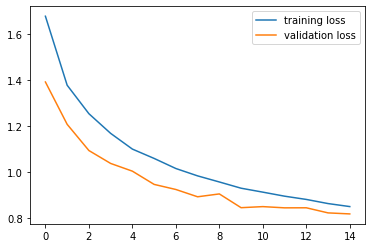

In [41]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

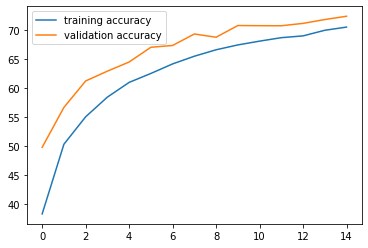

In [42]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

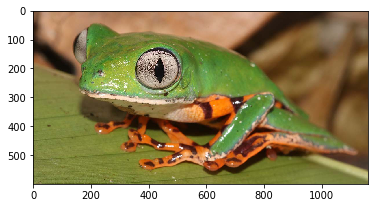

In [48]:
import requests
from PIL import Image
import PIL.ImageOps
url = 'https://www.nhm.ac.uk/content/dam/nhmwww/discover/jeff-frog-vision-field-work/Callimedusa_lemur_credit_Dr_Christian_Cox-%20full-width.jpg.thumb.1920.1920.png'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

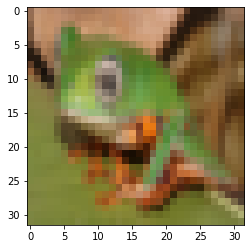

In [49]:
img = transform(img)
plt.imshow(img_convert(img))

In [50]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


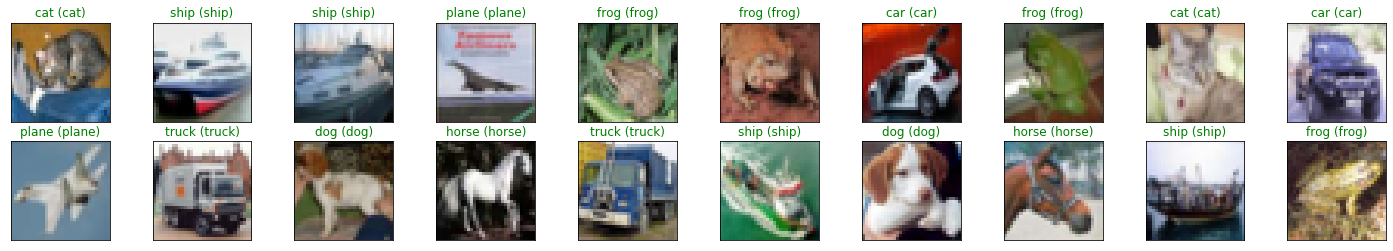

In [46]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4)) # w x h

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx] == labels[idx] else "red"))